# Feature Selection and GAM

This notebook presents the feature selection. The outcome is a feature ranking stored in *results/feature_rank.csv*.  

Then the construction of the GAM and Ridge models is detailed.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from heatmap import heatmap, corrplot

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import TweedieRegressor, Lasso, RidgeCV, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from pygam import GAM

------------------
# Load the dataset

In [42]:
df = pd.read_csv("../../processed_data/dataset_final.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M:%S')
# Set a DateTime index
df.set_index("Timestamp",drop=True, inplace=True)

In [12]:
# Split in a train dataset and a test dataset
df, df_test = train_test_split(df, test_size=0.20, random_state=42)

# Apply standardisation to all features except the target (Kc)
scaler = StandardScaler()
X_train = scaler.fit_transform(df[df.columns[:-1]])
X_test = scaler.transform(df_test[df.columns[:-1]])
y_train = df[["Kc"]]
y_test = df_test[["Kc"]]

Text(0.5, 1.0, 'Kc distribution')

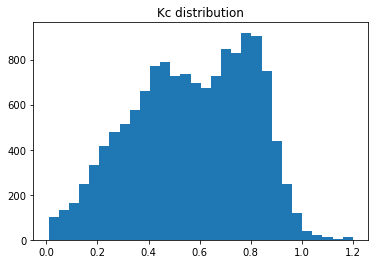

In [13]:
plt.hist(df.Kc, bins=30)
plt.title("Kc distribution")

-----------------------------

# Feature selection

NB : PCA is not an option since we would lose the interpretability of the model.

### Correlation to GHI

First, let's sort features with respect to correlation with GHI. This will give us an idea of the importance of each feature.

In [14]:
# Get correlation matrix
corr = df.corr()
np.mean(np.mean(np.abs(corr)))

0.26857936193484605

In [15]:
# Get list of correlations with Kc
Kc_pairs = corr.loc[["Kc"]].abs()
Kc_pairs = Kc_pairs.loc[:, df.columns[:-1]].sort_values(by=["Kc"], axis=1, ascending=False)
Kc_pairs

,gray_low_pass_circum0_std,gray_circum0_std,gray_low_pass_circum0_smoothness,gray_circum0_smoothness,rb_high_freq_energy,rb_low_freq_energy,rb_mid_freq_energy,gray_concentric0_entropy,sun_circularity_ratio,gray_circum0_entropy,...,high_pass_concentric0_skewness,high_pass_circum2_smoothness,high_pass_concentric2_skewness,high_pass_circum1_skewness,gray_low_pass_circum1_smoothness,gray_circum1_smoothness,high_pass_circum2_entropy,gray_low_pass_circum2_smoothness,gray_circum2_smoothness,high_pass_circum0_skewness
Kc,0.685103,0.680158,0.571779,0.557694,0.538447,0.537323,0.53307,0.507814,0.484025,0.482209,...,0.043054,0.042187,0.04191,0.038795,0.035245,0.031687,0.024746,0.023027,0.02017,0.016955


### Greedy Elimination (GE)

The idea of this approach is to iteratively elimnate features with respect to their correlation to other features. Therefore, the feature pair with the highest absolute correlation coefficient is selected. The feature of this pair which has the lower correlation with the GHI is eliminated. This procedure is repeated until no features are left.

The reverse order of elimination shall be the order of selecting features. For example if five features shall be selected for prediction than the five features which were eliminated last are to be chosen. 

In [16]:
# Get Top absolute correlation :

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [25]:
corr_pairs = get_top_abs_correlations(df)
corr_pairs.iloc[-6:]

gray_low_pass_concentric2_std   gray_low_pass_circum1_skewness    0.000262
gray_concentric2_mean           gray_circum1_skewness             0.000254
high_pass_concentric2_skewness  high_pass_circum1_smoothness      0.000219
gray_low_pass_circum1_mean      gray_low_pass_circum1_skewness    0.000154
gray_concentric1_smoothness     cloud_disparity                   0.000112
gray_low_pass_circum0_std       high_pass_concentric2_skewness    0.000065
dtype: float64

In [26]:
def feature_discard_order(corr_pairs, Kc_pairs):
    """returns a list of features. Describes how features should be discarded in order to have a selection of least correlated features."""

    # We don't want to analyse pairs that contain Kc, since it is the target.
    ToDelete = ["Kc"]
    count = 1
    for pair_names in corr_pairs.index:
        # We check that the currently analysed features have not been inspected before 
        if (pair_names[0] in ToDelete) | (pair_names[1] in ToDelete):
            continue
        else:
            if (Kc_pairs[pair_names[0]] > Kc_pairs[pair_names[1]]).bool():
                # We delete the feature that is the least correlated to GHI
                to_del = pair_names[1]
            else:
                to_del = pair_names[0]
            ToDelete.append(to_del)
            print(to_del + f" eliminated in {count}")
            count+=1
    # There is no more pair of features, but a last feature is missing in ToDelete 
    for feat in list(Kc_pairs.columns):
        if feat not in ToDelete:
            ToDelete.append(feat)
    discard_order = ToDelete[1:]
    return discard_order

In [27]:
discard_order = feature_discard_order(corr_pairs, Kc_pairs)

apparent_elevation eliminated in 1
elevation eliminated in 2
gray_concentric1_mean eliminated in 3
gray_concentric0_mean eliminated in 4
zenith eliminated in 5
gray_low_pass_concentric2_mean eliminated in 6
gray_concentric2_std eliminated in 7
gray_concentric1_std eliminated in 8
gray_low_pass_circum0_mean eliminated in 9
gray_concentric1_smoothness eliminated in 10
gray_concentric2_smoothness eliminated in 11
gray_circum1_mean eliminated in 12
gray_low_pass_circum2_mean eliminated in 13
gray_concentric0_std eliminated in 14
gray_concentric0_smoothness eliminated in 15
rb_mid_freq_energy eliminated in 16
gray_circum1_std eliminated in 17
gray_circum2_std eliminated in 18
rb_low_freq_energy eliminated in 19
gray_circum0_std eliminated in 20
gray_circum1_smoothness eliminated in 21
gray_circum2_smoothness eliminated in 22
gray_concentric2_skewness eliminated in 23
gray_circum0_smoothness eliminated in 24
gray_low_pass_circum1_mean eliminated in 25
gray_circum2_mean eliminated in 26
gray_

### Lasso Regularisation (LR)

We will inspect Regression coefficients to evaluate feature importance, for different $\lambda$ regularisation parameters.  

The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.



In [28]:
coefs_list = []
score_list = []
alphas = np.logspace(-4, 0, num=20)
for alpha in alphas:
    lasso = Lasso(alpha) # we already standardized the data
    lasso.fit(X_train, y_train)
    score_list.append(lasso.score(X_test, y_test))
    coefs_list.append(lasso.coef_)

/home/aconte/miniconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0998479610098855, tolerance: 0.07371133518302632
  positive)
/home/aconte/miniconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9869860256571599, tolerance: 0.07371133518302632
  positive)
/home/aconte/miniconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3337563808476034, tolerance: 0.07371133518302632
  positive)
/home/aconte/miniconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objec

In [29]:
num_features = [np.count_nonzero(coefs) for coefs in coefs_list]

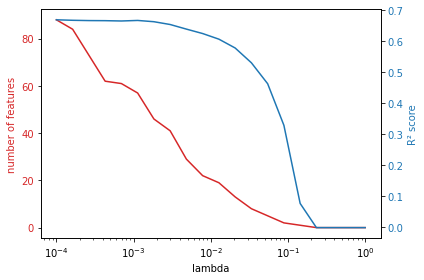

In [30]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('lambda')
ax1.set_ylabel('number of features', color=color)
ax1.plot(alphas, num_features, color=color)
plt.xscale("log")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R² score', color=color)  # we already handled the x-label with ax1
ax2.plot(alphas, score_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

The diagram above shows how many features were selected with respect to $\lambda$. The higher $\lambda$ became, the fewer features were selected. We can see that even if we only keep 20 features, the R² score would only drop from 0.68 to 0.65.  

Let's determine which features are dropped first as $\lambda$ raises. For each feature, we take the mean of the coefficient's absolute values, for various $\lambda$.   
We only keep coefficients from models whose R² is higher than 0.5. Indeed, as the Lasso's perfomance decreases, the feature selection thanks to this model becomes less relevant. 

In [33]:
score05 = np.where((np.array(score_list) < 0.5) & (np.array(score_list)>0.4), 1., 0.)
num_models_used = list(score05).index(1.)

In [34]:
weight_mat = np.array(coefs_list[:num_models_used])
weights_mean = np.mean(np.abs(weight_mat), axis=0)

In [35]:
LR_features = pd.DataFrame(weights_mean, index=df.columns[:-1], columns=["weights"]).sort_values(by=["weights"], ascending=False).T
LR_features

,gray_low_pass_circum0_std,gray_concentric0_mean,rb_high_freq_energy,gray_low_pass_circum2_mean,gray_circum1_std,gray_low_pass_circum1_std,high_pass_concentric2_mean,high_pass_concentric2_std,cloud_ratio,gray_low_pass_circum0_entropy,...,rb_mid_freq_energy,gray_mid_freq_energy,gray_concentric2_skewness,gray_concentric0_smoothness,high_pass_circum2_smoothness,high_pass_circum1_smoothness,gray_circum1_mean,apparent_elevation,gray_concentric1_std,gray_circum0_std
weights,0.070403,0.030546,0.029215,0.026576,0.026507,0.024738,0.024051,0.023609,0.019384,0.018384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Mutual information (MI)

In [37]:
mi = mutual_info_regression(X_train, y_train, discrete_features=False)
MI_order = pd.DataFrame(mi, index=df.columns[:-1], columns=["mutual_info"]).sort_values(by=["mutual_info"], ascending=False).T
MI_order

/home/aconte/miniconda3/envs/data/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,gray_circum0_std,gray_low_pass_circum0_std,gray_low_pass_circum0_smoothness,gray_circum0_smoothness,gray_circum0_mean,gray_low_pass_circum0_mean,gray_circum0_skewness,gray_low_pass_circum0_skewness,rb_mid_freq_energy,rb_low_freq_energy,...,gray_low_pass_circum2_smoothness,gray_low_pass_concentric0_entropy,gray_circum2_entropy,gray_circum2_smoothness,gray_circum2_skewness,gray_low_pass_circum2_std,gray_low_pass_circum2_skewness,gray_low_pass_circum2_entropy,gray_low_pass_circum1_entropy,high_pass_circum2_entropy
mutual_info,0.474928,0.472938,0.472343,0.472343,0.452333,0.451719,0.402899,0.379045,0.365903,0.364965,...,0.087124,0.087084,0.086591,0.085436,0.082233,0.081721,0.070144,0.054694,0.05413,0.038434



### Compare feature selection 

Let's compare feature importance order determined by each method.

In [38]:
GHI_order = list(Kc_pairs.columns) # Correlation to GHI
GE_order = discard_order[::-1]
LR_order = list(LR_features.columns)
MI_order = list(MI_order.columns)

In [39]:
f_rank = {}
for feature in df.columns[:-1]:
    f_rank[feature] = GHI_order.index(feature)*0.8
    f_rank[feature] += GE_order.index(feature)
    f_rank[feature] += LR_order.index(feature)
    f_rank[feature] += MI_order.index(feature)

In [42]:
f_rank = dict(sorted(f_rank.items(), key=lambda item: item[1]))
feature_rank = pd.DataFrame(np.arange(1, 108), index=f_rank.keys(), columns=["Rank"])
feature_rank[:20]

,Rank
gray_low_pass_circum0_std,1
rb_high_freq_energy,2
gray_low_pass_circum0_entropy,3
high_pass_circum0_entropy,4
gray_low_pass_circum0_skewness,5
sun_circularity_ratio,6
equation_of_time,7
gray_circum0_mean,8
gray_low_pass_concentric0_std,9
gray_circum0_entropy,10


In [28]:
feature_rank.to_csv("data/feature_rank.csv", date_format='%Y-%m-%d %H:%M:%S')

### Metrics for evaluation

In [55]:
def mape(predictions, targets):
    err = (predictions - targets)
    return 100*np.mean(np.abs(err))/np.mean(targets)

def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

In [56]:
def evaluate_pred(y_pred, y_test):
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    RMSE = rmse(y_pred, y_test)
    MAPE = mape(y_pred, y_test)
    R2 = r2_score(y_test, y_pred)
    print(f"RMSE = {RMSE} | MAPE = {MAPE} | R² = {R2}")

def baseline_scores(y_train, y_test):
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_hat = np.array([np.mean(y_train) for k in y_test])
    RMSE = rmse(y_hat, y_test)
    MAPE = mape(y_hat, y_test)
    R2 = r2_score(y_test, y_hat)
    print("baseline scores :")
    print(f"RMSE = {RMSE} | MAPE = {MAPE} | R² = {R2}")

--------------------------------

## Models

### Ridge regression

In [57]:
alphas = np.logspace(-2, 1, 20)
ridge = RidgeCV(alphas=alphas, scoring="neg_root_mean_squared_error")
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ]),
        scoring='neg_root_mean_squared_error')

In [58]:
y_pred = ridge.predict(X_test)
evaluate_pred(y_pred, y_test)
baseline_scores(y_train, y_test)
f" regularisation parameter = {ridge.alpha_}"

RMSE = 0.1523458188614407 | MAPE = 16.9692303934464 | R² = 0.5697600228955003
baseline scores :
RMSE = 0.23236635940269842 | MAPE = 35.091214241662726 | R² = -0.0009126780419199676


' regularisation parameter = 0.01'

De bonnes performances sur l'ensemble des features. Stratégie de CV: Leave-One-Out. Dans la suite on conserve $\alpha = 0.01$.

In [59]:
Ridge_weights = pd.DataFrame(np.abs(ridge.coef_).T, index=df.columns[:-1], columns=["weights"]).sort_values(by=["weights"], ascending=False).T
Ridge_weights

,zenith,elevation,apparent_elevation,apparent_zenith,gray_concentric1_smoothness,gray_low_pass_concentric1_smoothness,gray_concentric2_smoothness,gray_low_pass_concentric2_smoothness,gray_concentric1_std,gray_low_pass_concentric1_std,...,gray_circum0_skewness,high_pass_concentric0_mean,high_pass_concentric0_skewness,gray_low_pass_circum2_entropy,rb_high_freq_energy,high_pass_circum1_entropy,gray_circum2_entropy,gray_circum0_smoothness,gray_circum2_mean,high_pass_concentric1_mean
weights,10.993213,10.993213,10.970055,10.970055,2.922543,2.802467,2.066356,1.981077,1.315693,1.262869,...,0.002964,0.002889,0.002512,0.002055,0.002005,0.001862,0.001711,0.001455,0.00115,0.000775


Mais redondance dans les features utilisées, et difficulté à interpréter les 107 poids. Comment se comporte le modèle avec moins de features ?

In [60]:
def plot_metrics(num_f):
    RMSE_val = []
    MAPE_val = []
    for k in num_f:
        selected_columns = feature_rank[:k].index
        X = np.array(df.loc[:, selected_columns])
        y = np.array(df[["Kc"]])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

        ridge = Ridge(alpha=0.01)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        RMSE_val.append(rmse(y_pred, y_test))
        MAPE_val.append(mape(y_pred, y_test))
    return RMSE_val, MAPE_val

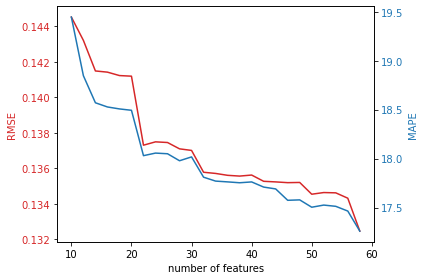

In [61]:
num_f = np.arange(10, 60, 2)
to_plot = plot_metrics(num_f)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('number of features')
ax1.set_ylabel("RMSE", color=color)
ax1.plot(num_f, to_plot[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MAPE', color=color)  # we already handled the x-label with ax1
ax2.plot(num_f, to_plot[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

In [62]:
k = 20
selected_columns = feature_rank[:k].index
X_train20 = df.loc[:, selected_columns]
y_train20 = df[["Kc"]]
X_test20 = df_test.loc[:, selected_columns]
y_test20 = df_test[["Kc"]]

ridge = Ridge(alpha=0.01)
ridge.fit(X_train20, y_train20)
y_pred = ridge.predict(X_test20)
evaluate_pred(y_pred, y_test20)
baseline_scores(y_train20, y_test20)

RMSE = 0.14543898182974088 | MAPE = 19.126003804161236 | R² = 0.6078869161664178
baseline scores :
RMSE = 0.23236635940269842 | MAPE = 35.091214241662726 | R² = -0.0009126780419199676


In [63]:
Ridge_weights = pd.DataFrame(np.abs(ridge.coef_).T, index=selected_columns, columns=["weights"]).sort_values(by=["weights"], ascending=False).T
Ridge_weights

,gray_circum0_smoothness,rb_high_freq_energy,high_pass_concentric1_std,gray_low_pass_circum0_std,rb_low_freq_energy,high_pass_circum0_std,gray_low_pass_concentric0_std,gray_concentric2_mean,gray_low_pass_concentric1_std,sun_circularity_ratio,gray_circum0_mean,gray_low_pass_circum0_entropy,gray_circum0_entropy,gray_concentric0_entropy,high_pass_concentric0_entropy,high_pass_concentric1_entropy,high_pass_circum0_entropy,gray_circum1_entropy,gray_low_pass_circum0_skewness,equation_of_time
weights,10.519708,3.821824,3.667983,3.385838,2.597242,0.856463,0.695346,0.365158,0.234915,0.073639,0.042684,0.038652,0.026063,0.015494,0.012747,0.012228,0.010419,0.004474,0.003704,0.002771


(0.0, 1.0)

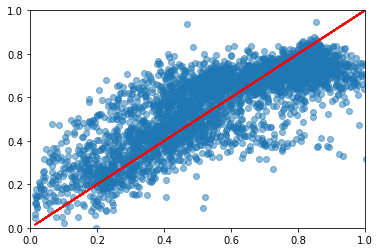

In [64]:
plt.scatter(y_test20, y_pred, alpha=0.5)
plt.plot(y_test20, y_test20, c="r")
plt.xlim(0, 1)
plt.ylim(0, 1)

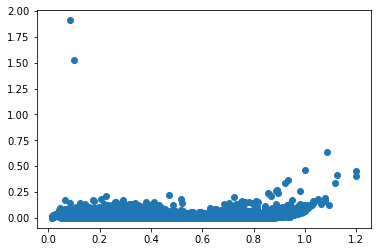

In [65]:
residual = (y_pred - y_test20)**2
plt.scatter(y_test20, residual)

Calculer la proportion de variance expliquée par le résultat d'une regression qui repose sur des produits de features.

Possible de forcer le modèle à utiliser les features issues de la selection. Permet de gagner en cohérence et donc en interprétabilité du modèle. En revanche, légère perte de performance.  
 
Est-il possible d'augmenter l'interprétabilité (i.e. influence de chaque feature) tout en conservant les performances ?

### Generalized Linear Model (GLM)

* Distribution Gamma n'est pas définie en 0.  

* If the target values are positive valued and skewed, you might try a Gamma deviance with log-link.

* When performing cross-validation for the power parameter of TweedieRegressor, it is advisable to specify an explicit scoring function, because the default scorer TweedieRegressor.score is a function of power itself.  

####  Gridsearch sur *alpha*, *link* et *power*

> Conclusion : {'alpha': 0.01, 'link': 'log', "power": 1.}. Distribution pertinente : Poisson

In [66]:
reg = TweedieRegressor(link="log", power=1., alpha=0.01, max_iter=1000)
# underlying target distribution : Poisson
reg.fit(X_train20, y_train20)

TweedieRegressor(alpha=0.01, link='log', max_iter=1000, power=1.0)

In [67]:
y_pred = reg.predict(X_test20)
evaluate_pred(y_pred, y_test20)
baseline_scores(y_train20, y_test20)

RMSE = 0.2893943885675239 | MAPE = 41.95280878572927 | R² = 0.5598525547206785
baseline scores :
RMSE = 0.23236635940269842 | MAPE = 35.091214241662726 | R² = -0.0009126780419199676


Performs worse than mean value of train dataset.

### GAM model

* Distribution Gamma is not defined in 0.    

* If the target values are positive valued and skewed, you might try a Gamma deviance with log-link.

In [68]:
from pygam import GAM, l, s

In [69]:
# model
gam = GAM(distribution="poisson", link="log")
X_train20_array = np.array(X_train20)
y_train20_array = np.array(y_train20)
gam.gridsearch(X_train20_array, y_train20_array)

100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


GAM(callbacks=[Deviance(), Diffs()], distribution=PoissonDist(), 
   fit_intercept=True, link=LogLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + intercept,
   tol=0.0001, verbose=False)

In [70]:
y_pred = gam.predict(X_test20)
evaluate_pred(y_pred, y_test20)
baseline_scores(y_train20, y_test20)

RMSE = 0.30088791484744815 | MAPE = 43.47355601192772 | R² = 0.6770925298461692
baseline scores :
RMSE = 0.23236635940269842 | MAPE = 35.091214241662726 | R² = -0.0009126780419199676


In [71]:
selected_columns

Index(['gray_low_pass_circum0_std', 'rb_high_freq_energy',
       'gray_low_pass_circum0_entropy', 'high_pass_circum0_entropy',
       'gray_low_pass_circum0_skewness', 'sun_circularity_ratio',
       'equation_of_time', 'gray_circum0_mean',
       'gray_low_pass_concentric0_std', 'gray_circum0_entropy',
       'high_pass_concentric1_entropy', 'gray_low_pass_concentric1_std',
       'gray_concentric0_entropy', 'gray_circum0_smoothness',
       'high_pass_concentric0_entropy', 'rb_low_freq_energy',
       'gray_concentric2_mean', 'high_pass_concentric1_std',
       'high_pass_circum0_std', 'gray_circum1_entropy'],
      dtype='object')

In [72]:
def plot_partial_dep(fitted_model, features):
    ## plotting k partial dependencies
    k = len(features)
    fig, axs = plt.subplots(1,k, figsize=(14, 6))
    feature_nums = [list(selected_columns).index(title) for title in features]
    for j, (i, ax) in enumerate(zip(feature_nums, axs)):
        XX = fitted_model.generate_X_grid(term=i)
        ax.plot(XX[:, i], fitted_model.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], fitted_model.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        if j==0:
            ax.set_ylabel("Kc (=GHI/GHI_clearsky)")
        ax.set_title(features[j])

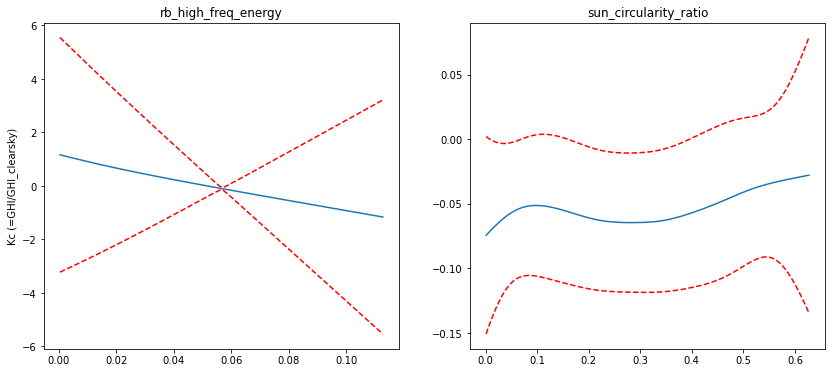

In [73]:
features = ['rb_high_freq_energy','sun_circularity_ratio']
plot_partial_dep(gam, features)

In [74]:
Ridge_weights

,gray_circum0_smoothness,rb_high_freq_energy,high_pass_concentric1_std,gray_low_pass_circum0_std,rb_low_freq_energy,high_pass_circum0_std,gray_low_pass_concentric0_std,gray_concentric2_mean,gray_low_pass_concentric1_std,sun_circularity_ratio,gray_circum0_mean,gray_low_pass_circum0_entropy,gray_circum0_entropy,gray_concentric0_entropy,high_pass_concentric0_entropy,high_pass_concentric1_entropy,high_pass_circum0_entropy,gray_circum1_entropy,gray_low_pass_circum0_skewness,equation_of_time
weights,10.519708,3.821824,3.667983,3.385838,2.597242,0.856463,0.695346,0.365158,0.234915,0.073639,0.042684,0.038652,0.026063,0.015494,0.012747,0.012228,0.010419,0.004474,0.003704,0.002771


Donne des informations sur l'influence de chaque feature. Cependant le modèle est améliorable, comme en témoigne les intervalles de confiance.  

On peut alors mettre à jour le modèle GAM. En effet, on observe par exemple une dépendance linéaire de Kc en fonction de *rb_high_freq_energy*.  